# 1. 前期准备

In [1]:
from transformers import AutoTokenizer, AutoModel
from tqdm.notebook import trange
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
model_dir = ".cache/modelscope/hub/ZhipuAI/chatglm3-6b"
tokenizer = AutoTokenizer.from_pretrained(model_dir, trust_remote_code=True)
model = AutoModel.from_pretrained(
    model_dir, trust_remote_code=True, device="cuda"
).eval()

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

# 2. 导入数据

In [5]:
test_dataset = pd.read_csv("./test_dataset.csv")
test_dataset.head()

,joke,label,len_joke,标签,pinyin
0,车上遇见一对双胞胎姑娘。穿的那个清凉啊，笑的那个甜啊……忍不住要去搭讪。 为不表现的轻浮和唐...,2,83,强幽默,che1 shang4 yu4 jian4 yi1 dui4 shuang1 bao1 ta...
1,图书馆自习室每个桌面上都摆满了占座的书，很是让其他人气愤。 某生不占座没有固定的座位，一日去...,0,192,弱幽默,tu2 shu1 guan3 zi4 xi2 shi4 mei3 ge4 zhuo1 mia...
2,一个报童在大街上高声叫卖：骇人听闻的诈骗案，受害者多达82人！ 某行人连忙上前买一份。可是，...,2,102,强幽默,yi1 ge4 bao4 tong2 zai4 da4 jie1 shang4 gao1 s...
3,法官对被告说：你不但偷钱，还拿了表，戒指和珍珠。 被告说：是的，法官先生，人们不是常说‘光有...,2,56,强幽默,fa3 guan1 dui4 bei4 gao4 shuo1 ： ni3 bu4 dan4 ...
4,大人，原告在法庭上说，这个人同我一起生活了几天，答应同我结婚，可是后来他同别的女人结了婚。他...,1,140,一般幽默,da4 ren2 ， yuan2 gao4 zai4 fa3 ting2 shang4 sh...


In [6]:
content_list = test_dataset["joke"].to_list()

# 3. 生成回答

In [10]:
generate_prompt = "你是一位语言学家，请你判断以下文本的幽默程度，输出分类只能是'弱幽默','一般幽默','强幽默'三者之一，不能包含其它符号。"

In [14]:
def detect_humor_level(text):
    humor_levels = ["弱幽默", "一般幽默", "强幽默"]
    detected_levels = []

    for level in humor_levels:
        if level in text:
            detected_levels.append(level)

    if len(detected_levels) == 1:
        return detected_levels[0]
    elif len(detected_levels) > 1:
        return "警告：同时拥有两种或以上幽默水平"
    else:
        return "警告：未检测到幽默水平"


# 示例用法
text = "这个笑话真的很弱幽默，但又有一些一般幽默的味道。"
print(detect_humor_level(text))

警告：同时拥有两种或以上幽默水平


In [16]:
response1 = []
max_retry = 5
outliers_count = 0
for i in trange(len(content_list)):
    retry = 0
    query = generate_prompt + "文本如下：\n" + content_list[i]
    while retry < max_retry:
        history = []
        response, history = model.chat(tokenizer, query, history=history)
        if response in ["弱幽默", "一般幽默", "强幽默"]:
            response1.append(response)
            break
        else:
            response_tmp = detect_humor_level(response)
            if response_tmp in ["弱幽默", "一般幽默", "强幽默"]:
                response1.append(response_tmp)
                break
            else:
                retry += 1
    if retry == max_retry:
        print(f"Warning:数据{i}生成了不合规范的回答！生成的结果为：{response}")
        outliers_count += 1
print(f"回答生成完毕！比较过程中，共生成{outliers_count}个不合规范的回答。")

  0%|          | 0/3130 [00:00<?, ?it/s]

2. '一般幽默'
3. '强幽默'
回答生成完毕！比较过程中，共生成2个不合规范的回答。


In [19]:
response1.insert(902, "强幽默")
response1.insert(2059, "弱幽默")
len(response1)

3130

# 4. 结果评估

In [20]:
test_dataset["预测标签"] = response1
test_dataset["预测标签"].value_counts()

预测标签
强幽默     1917
一般幽默    1153
弱幽默       60
Name: count, dtype: int64

In [21]:
test_dataset["pred_label"] = test_dataset["预测标签"].replace(
    {"弱幽默": 0, "一般幽默": 1, "强幽默": 2}
)

/tmp/ipykernel_110564/3744847549.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_dataset["pred_label"] = test_dataset["预测标签"].replace(


In [22]:
from sklearn import metrics


def evaluate(targets, outputs):
    conf = metrics.confusion_matrix(targets, outputs)
    data = pd.DataFrame(
        conf,
        columns=["weak humor", "general humor", "strong humor"],
        index=["weak humor", "general humor", "strong humor"],
    )
    plt.figure(figsize=(6, 5))
    sns.heatmap(data, cmap=plt.cm.Blues, annot=True, fmt="d")
    plt.xlabel("Predict label")
    plt.ylabel("True label")
    plt.title("Confusion Matrix", fontsize=16)
    plt.show()
    print("Classification Report")
    print(metrics.classification_report(targets, outputs))

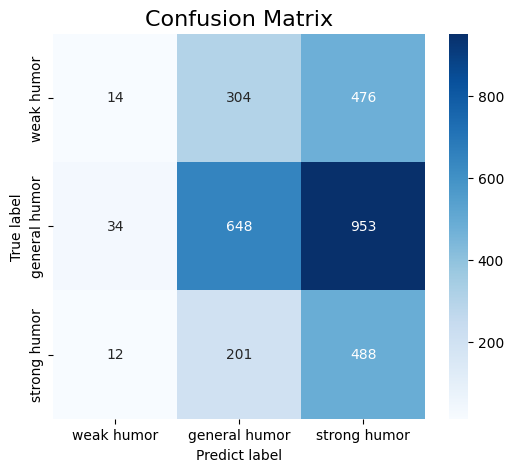

Classification Report
              precision    recall  f1-score   support

           0       0.23      0.02      0.03       794
           1       0.56      0.40      0.46      1635
           2       0.25      0.70      0.37       701

    accuracy                           0.37      3130
   macro avg       0.35      0.37      0.29      3130
weighted avg       0.41      0.37      0.33      3130



In [23]:
evaluate(test_dataset["label"], test_dataset["pred_label"])